In [469]:
from pathlib import Path
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from timeit import default_timer as timer
from sklearn.metrics import mean_squared_error

import xgboost as xgb

plt.style.use("fivethirtyeight")

path = Path("mdsb-2023")

In [470]:
def add_lags(X, cols_to_lag=["t", "u", "vv", "nnuage4"], lag_list=[2, -24, -2]):
    X = X.copy()

    feature_columns = [col for col in X.columns if col in cols_to_lag]

    for l in lag_list:
        lag_columns = [f"{col}_lag{l}" for col in feature_columns]
        X[lag_columns] = X[feature_columns].shift(periods=l, axis=0)
        X[lag_columns] = (
            X[lag_columns]
            .interpolate(method="linear")
            .interpolate(method="bfill")
            .interpolate(method="ffill")
        )

    return X


def add_moving_average(
    X, cols_to_ma=["t", "u", "vv", "nnuage4"], window_list=[24 * 7, 24], centered=True
):
    X = X.copy()

    feature_columns = [col for col in X.columns if col in cols_to_ma]

    for w in window_list:
        ma_columns = [f"{col}_ma{w}" for col in feature_columns]
        X[ma_columns] = X[feature_columns].rolling(window=w, center=centered).mean()
        X[ma_columns] = (
            X[ma_columns]
            .interpolate(method="linear")
            .interpolate(method="bfill")
            .interpolate(method="ffill")
        )

    return X

### Define pipeline functions

In [471]:
from workalendar.europe import France


def _encode_dates(X, col_name="date"):
    X = X.copy()

    #     X["year"] = X[col_name].dt.year
    X["month"] = X[col_name].dt.month
    #     X["day"] = X[col_name].dt.day
    X["weekday"] = X[col_name].dt.weekday
    X["hour"] = X[col_name].dt.hour
    #     X['isweekend'] = X[col_name].apply(lambda x: 0 if x.weekday() in range(5) else 1)

    #     cal = France()
    #     X['is_holiday'] = X['date'].apply(cal.is_holiday)
    #     X['working_day'] = X['date'].apply(cal.is_working_day)

    #     X[["month", "weekday", "hour"]] = X[["month", "weekday", "hour"]].astype("category")

    return X.drop(columns=[col_name])

In [472]:
def _encode_covid(X, col_name="date"):
    X = X.copy()

    # Create masks for lockdown dates
    lockdown_1 = (X["date"] >= "2020-10-17") & (
        X["date"] <= "2020-12-14"
    )  # & ((X['date'].dt.hour >= 21) | (X['date'].dt.hour <= 6))

    lockdown_2 = (X["date"] >= "2020-12-15") & (
        X["date"] <= "2021-02-26"
    )  # & ((X['date'].dt.hour >= 18) | (X['date'].dt.hour <= 6))

    lockdown_3 = (X["date"] >= "2021-02-27") & (
        X["date"] <= "2021-05-02"
    )  # & ((X['date'].dt.hour >= 19) | (X['date'].dt.hour <= 6))

    X["Covid"] = 0
    X.loc[lockdown_1 | lockdown_2 | lockdown_3, "Covid"] = 1

    return X

In [473]:
def _merge_external_data(X, include_lags=1, include_ma=1):
    to_keep = [
        "date",
        "hnuage4",
        "t",
        "ctype4",
        "nnuage4",
        "u",
        "etat_sol",
        "perssfrai",
        "tx12",
        "cm",
        "tn12",
        "tend24",
        "vv",
        "rafper",
        "rr24",
        "hnuage2",
        "td",
        "rr3",
        "hnuage3",
        "hnuage1",
    ]

    ext_data = pd.read_csv(path / "external_data.csv", parse_dates=["date"])[to_keep]

    ext_data.drop(columns=ext_data.columns[ext_data.isna().sum() > 1000])

    full_date_range = pd.date_range(
        start=np.min([np.min(data.date), np.min(test.date)]),
        end=np.max([np.max(data.date), np.max(test.date)]),
        freq="H",
    )
    full_date_range = pd.DataFrame({"date": full_date_range})

    ext_data = full_date_range.merge(ext_data, on="date", how="left")

    columns_to_interpolate = ext_data.drop(columns="date").columns
    ext_data[columns_to_interpolate] = (
        ext_data[columns_to_interpolate]
        .interpolate(method="polynomial", order=3)
        .interpolate(method="bfill")
        .interpolate(method="ffill")
    )

    if include_lags:
        ext_data = add_lags(ext_data)

    if include_ma:
        ext_data = add_moving_average(ext_data)

    to_drop = to_drop = [
        "vv_lag2",
        "t_lag-24",
        "u_lag-24",
        "vv_lag-24",
        "tx12",
        "nnuage4_lag-2",
        "etat_sol",
        "vv_lag-2",
        "u",
        "nnuage4",
        "ctype4",
        "t",
        "u_lag2",
        "vv_ma24",
        "t_lag2",
        "tend24",
        "u_ma24",
        "nnuage4_ma24",
        "vv_ma168",
        "cm",
        "hnuage1",
        "hnuage3",
        "rr3",
        "td",
        "hnuage2",
        "rr24",
        "rafper",
        "vv",
        "u_ma168",
        "hnuage4",
    ]

    ext_data.drop(columns=to_drop, inplace=True)

    X = X.copy()

    X["date"] = X["date"].astype("datetime64[ns]")
    ext_data["date"] = ext_data["date"].astype("datetime64[ns]")

    X["orig_index"] = np.arange(X.shape[0])
    X = pd.merge_asof(X.sort_values("date"), ext_data.sort_values("date"), on="date")

    # Sort back to the original order
    X = X.sort_values("orig_index")
    del X["orig_index"]

    return X

In [474]:
def _gas_price_encoder(X):
    X = X.copy()
    X["gas_price"] = 1
    gas_prices = np.array(
        [
            1.22,
            1.21,
            1.22,
            1.27,
            1.31,
            1.36,
            1.4,
            1.39,
            1.4,
            1.43,
            1.45,
            1.45,
            1.46,
            1.56,
        ]
    )
    years = [
        2020,
        2020,
        2020,
        2020,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
        2021,
    ]
    months = [9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    for i, price in enumerate(gas_prices):
        X.loc[
            (X.date.dt.month == months[i]) & (X.date.dt.year == years[i]), "gas_price"
        ] = price

    return X

## Import main dataset

In [475]:
data = pd.read_parquet(path / "train.parquet")

targets = ["bike_count", "log_bike_count"]
data = data[targets + list(data.drop(columns=targets))]

data.sample(2)

,bike_count,log_bike_count,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
810373,21.0,3.091042,100057380-103057380,Totem Cours la Reine O-E,100057380,Totem Cours la Reine,2021-02-14 18:00:00,2020-02-11,"48.86462,2.31444",YTH19111509,48.86462,2.31444
357638,136.0,4.919981,100047548-103047548,Face au 25 quai de l'Oise NE-SO,100047548,Face au 25 quai de l'Oise,2021-03-04 07:00:00,2018-11-28,"48.89141,2.38482",Y2H18086324,48.89141,2.38482


In [476]:
test = pd.read_parquet(path / "final_test.parquet")

In [477]:
data.drop(
    columns=[
        "site_name",
        "counter_id",
        "site_id",
        "counter_installation_date",
        "coordinates",
        "counter_technical_id",
    ],
    inplace=True,
)
test.drop(
    columns=[
        "site_name",
        "counter_id",
        "site_id",
        "counter_installation_date",
        "coordinates",
        "counter_technical_id",
    ],
    inplace=True,
)

## Model

In [478]:
def train_test_split_temporal(X, y, delta_threshold="60 days"):

    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = X["date"] <= cutoff_date
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [479]:
X, y = data.drop(columns=targets), data["log_bike_count"]

In [480]:
X_train, y_train, X_test, y_test = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Test: n_samples={X_test.shape[0]},  {X_test["date"].min()} to {X_test["date"].max()}'
)

Train: n_samples=416187,  2020-09-01 01:00:00 to 2021-07-11 23:00:00
Test: n_samples=80640,  2021-07-12 00:00:00 to 2021-09-09 23:00:00


In [481]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (
    RandomForestRegressor,
    HistGradientBoostingRegressor,
    BaggingRegressor,
)
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures


target_name = "log_bike_count"

poly_transformer = PolynomialFeatures(degree=2, include_bias=False)

categorical_encoder = OrdinalEncoder()

data_merger = FunctionTransformer(_merge_external_data, validate=False)
covid_encoder = FunctionTransformer(_encode_covid, validate=False)
date_encoder = FunctionTransformer(_encode_dates, validate=False)
gas_encoder = FunctionTransformer(_gas_price_encoder, validate=False)
# capacity_merger = FunctionTransformer(_merge_capacity, validate=False)

date_cols = _encode_dates(X_train[["date"]]).columns.tolist()
categorical_cols = ["counter_name"]  # + date_cols
numerical_cols = (
    _merge_external_data(X_train).select_dtypes(include=np.number).columns.tolist()
)

lag_encoder = FunctionTransformer(
    lambda X: add_lags(X, cols_to_lag=date_cols, lag_list=[1]), validate=False
)

In [485]:
preprocessor = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_cols),
        #         ("standard scaler", StandardScaler(), numerical_cols)
        #         ("poly", poly_transformer, ["t", "u", "n"])
    ]
)
# {'learning_rate': 0.16263414906434522, 'n_estimators': 633}
best_params = {  # lr 0.2, md 8, ne 450, ss 0.8
    "learning_rate": 0.16,
    "max_depth": 8,
    "n_estimators": 630,
    "subsample": 0.8,
    "od_pval": 1e-5
    #     'colsample_bylevel': 0.8
}

regressor = CatBoostRegressor(**best_params)
# regressor = xgb.XGBRegressor(enable_categorical=True, max_cat_to_onehot=60, **best_params)

pipe = Pipeline(
    [
        #         ('merge capacity', capacity_merger),
        ("merge external", data_merger),
        ("gas prices encoder", gas_encoder),
        ("covid encoder", covid_encoder),
        ("date encoder", date_encoder),
        #         ('lag encoder', lag_encoder),
        #         ('preprocessor', preprocessor),
        ("regressor", regressor),
    ]
)

In [420]:
import optuna


def objective(trial):
    # Define hyperparameters to optimize
    learning_rate = trial.suggest_float("learning_rate", 0.1, 0.25)
    max_depth = trial.suggest_int("max_depth", 5, 9)
    n_estimators = trial.suggest_int("n_estimators", 250, 1000)
    subsample = trial.suggest_float("subsample", 0.7, 0.95)
    colsample_bylevel = trial.suggest_float("colsample_bylevel", 0.9, 1.0)

    regressor = CatBoostRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        subsample=subsample,
        od_pval=1e-5
        #         colsample_bylevel=colsample_bylevel
    )

    pipe = Pipeline(
        [
            ("merge external", data_merger),
            ("gas prices encoder", gas_encoder),
            ("covid encoder", covid_encoder),
            ("date encoder", date_encoder),
            ("regressor", regressor),
        ]
    )

    # Perform temporal train-test split
    X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

    val_pool = Pool(
        _encode_dates(_merge_external_data(X_valid)),
        label=y_valid,
        cat_features=categorical_cols,
    )

    # Fit the pipeline on the training data
    pipe.fit(
        X_train,
        y_train,
        regressor__cat_features=categorical_cols,
        regressor__early_stopping_rounds=130,
        regressor__eval_set=val_pool,
    )

    # Make predictions on the validation set
    predictions = pipe.predict(X_valid)

    # Calculate the mean squared error as the objective
    neg_rmse = -mean_squared_error(y_valid, predictions, squared=False)

    return neg_rmse


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Get the best parameters from the study
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2023-12-10 19:32:19,539] A new study created in memory with name: no-name-b375dac9-c8c0-461d-8d8b-f3e7233c34c8
[W 2023-12-10 19:32:22,274] Trial 0 failed with parameters: {'learning_rate': 0.2310212044143503, 'max_depth': 9, 'n_estimators': 284, 'subsample': 0.7426434985280601, 'colsample_bylevel': 0.9364553919501227} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\nicol\anaconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\nicol\AppData\Local\Temp\ipykernel_33672\4252459182.py", line 35, in objective
    pipe.fit(X_train, y_train, regressor__cat_features=categorical_cols, regressor__early_stopping_rounds=130, regressor__eval_set=val_pool)
  File "C:\Users\nicol\anaconda3\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\nicol\anaconda3\lib\site-packages\sklearn\pipeline.py", l

KeyboardInterrupt: 

In [486]:
# X_train, y_train, X_val, y_val = train_test_split_temporal(X_train, y_train, "45 days")
val_pool = Pool(
    _encode_dates(_encode_covid(_gas_price_encoder(_merge_external_data(X_test)))),
    label=y_test,
    cat_features=categorical_cols,
)
pipe.fit(
    X_train, y_train
)  # , regressor__cat_features=categorical_cols, regressor__early_stopping_rounds=70, regressor__eval_set=val_pool)

Pipeline(steps=[('merge external',
                 FunctionTransformer(func=<function _merge_external_data at 0x0000020B81578CA0>)),
                ('date encoder',
                 FunctionTransformer(func=<function _encode_dates at 0x0000020BA068AA70>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['counter_name'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callb...
                              feature_types=None, gamma=0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.13,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None, min_child_weight=7,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=790,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])

In [448]:
# pipe.named_steps['regressor'].get_all_params()

In [487]:
y_hat = pipe.predict(X_test)

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(f"Test set, RMSE={mean_squared_error(y_test, y_hat, squared=False):.2f}")

Train set, RMSE=1.56
Test set, RMSE=1.28


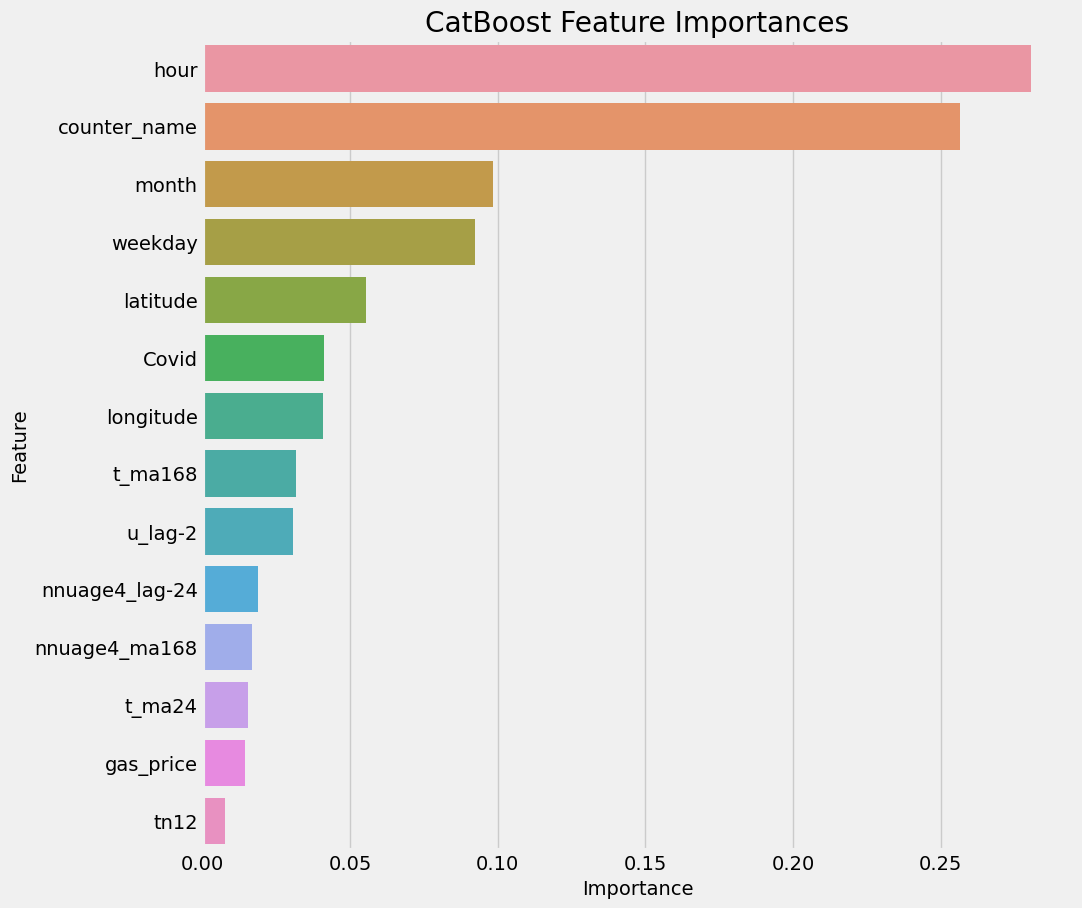

In [450]:
feature_names = _encode_dates(
    _encode_covid(_gas_price_encoder(_merge_external_data(X_test)))
).columns.tolist()  # Assuming encode functions keep column names

# Combine feature names and importances
feature_importances = pd.DataFrame(
    {
        "Feature": feature_names,
        "Importance": np.abs(pipe.named_steps["regressor"].feature_importances_)
        / (np.sum(np.abs(pipe.named_steps["regressor"].feature_importances_))),
    }
)

# Sort by importance
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x="Importance", y="Feature", data=feature_importances.iloc[:, :])
plt.title("CatBoost Feature Importances")
plt.show()

In [436]:
feature_importances.iloc[-3:, :].Feature.tolist()

['t_lag-2', 'nnuage4_lag2', 'perssfrai']

## Visual

<Axes: xlabel='date'>

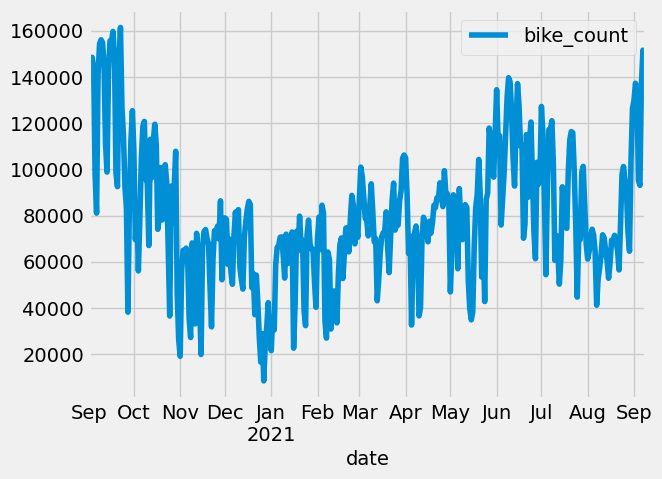

In [806]:
mask = (data["date"] > pd.to_datetime("2020/12/20")) & (
    data["date"] < pd.to_datetime("2020/12/29")
)

data[:].groupby(pd.Grouper(freq="1d", key="date"))[["bike_count"]].sum().plot()

Text(0, 0.5, 'bike_count')

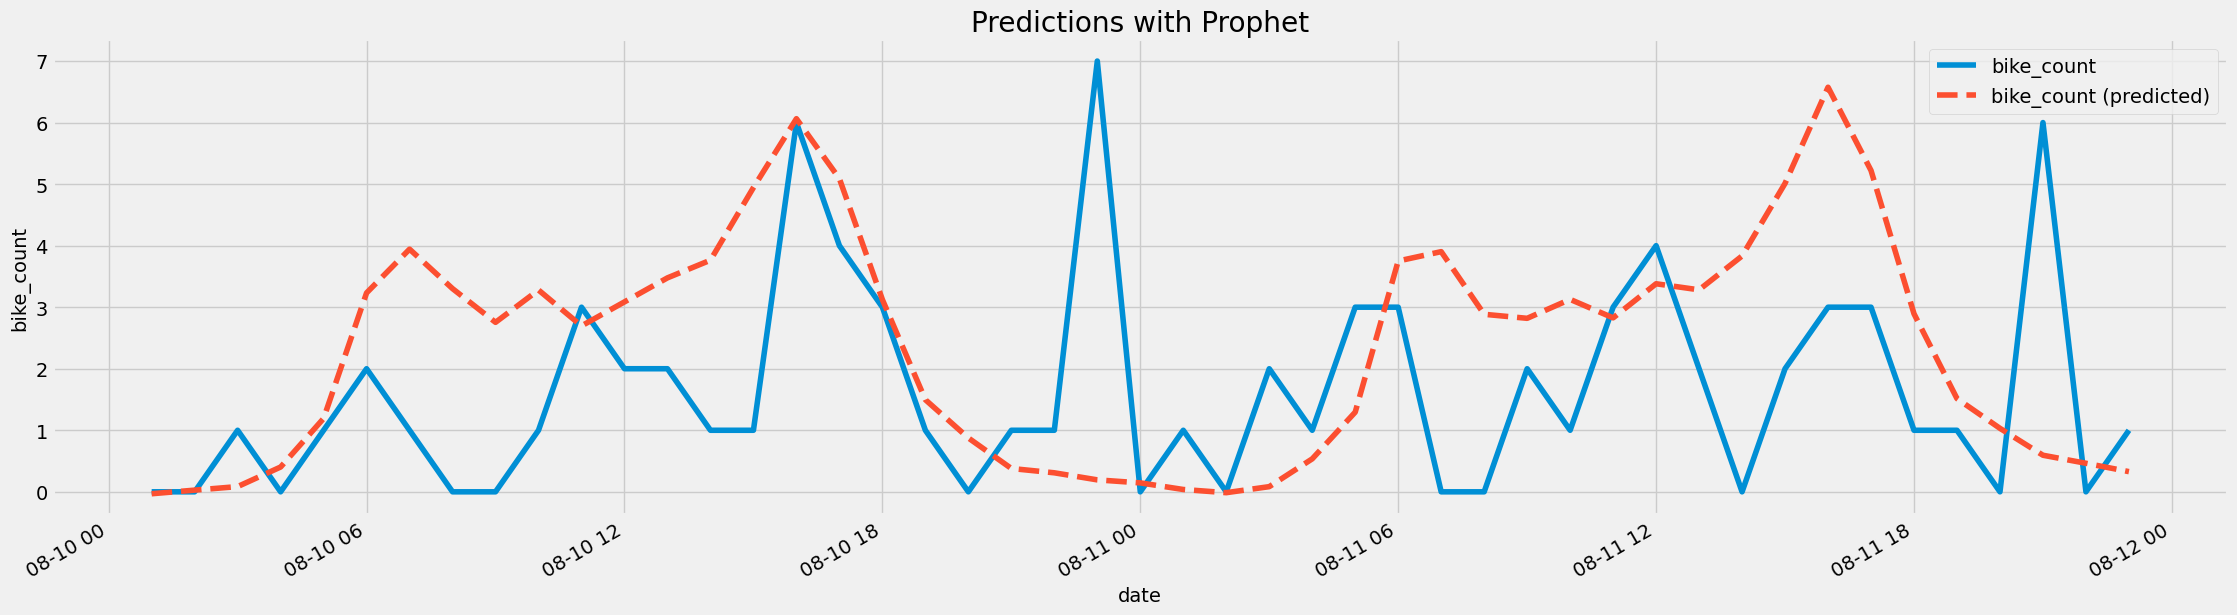

## Hyperparameter optimization analysis

In [39]:
# param1 = list(param_grid.keys())[0]
# param2 = list(param_grid.keys())[1]
# p1_name = param1.split('__')[1]
# p2_name = param2.split('__')[1]

# # Extract the relevant information for plotting vs the max_depth parameter
# mean_test_scores_depth = np.sqrt(-grid_search.cv_results_['mean_test_score'].reshape(len(param_grid[param1]), -1))
# n_estimators_values = param_grid[param2]

# # Extract the relevant information for plotting vs the n_estimators parameter
# mean_test_scores_estimators = np.sqrt(-grid_search.cv_results_['mean_test_score'].reshape(len(param_grid[param1]), -1)).T
# max_depth_values = param_grid[param1]

# # Start plot
# fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# # Plot a line for each max_depth value
# for i, max_depth in enumerate(max_depth_values):
#     if max_depth in []:
#         continue
#     ax[0].plot(n_estimators_values, mean_test_scores_depth[i, :], label=f"{p1_name}={max_depth}", marker='o', alpha=0.6)

# ax[0].set_title('Mean Test Score vs. n_estimators')
# ax[0].set_xlabel('n_estimators')
# ax[0].set_ylabel('Mean Test Score (Negative MSE)')
# ax[0].legend(title='Max Depth', prop={'size': 10})
# ax[0].grid(True)

# # Plot a line for each n_estimators value
# for i, n_est in enumerate(n_estimators_values):
#     ax[1].plot(max_depth_values, mean_test_scores_estimators[i, :], label=f'{p2_name}={n_est}', marker='o', alpha=0.6)

# ax[1].set_title('Mean Test Score vs. max_depth')
# ax[1].set_xlabel('max_depth')
# ax[1].set_ylabel('Mean Test Score (Negative MSE)')
# ax[1].legend(title='n_estimators', prop={'size': 10})
# ax[1].grid(True)

# plt.tight_layout()
# plt.show()

## Feature importance analysis 

In [18]:
X

48321     9
48324     9
48327     9
48330     9
48333     9
         ..
929175    9
929178    9
929181    9
929184    9
929187    9
Name: date, Length: 496827, dtype: int64

In [40]:
# import shap

In [41]:
# explainer = shap.Explainer(pipe)

# shap_values = explainer(X_train)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

# Submission

In [45]:
pipe.fit(X, y)
prediction = pipe.predict(test)
prediction[prediction < 0] = 0

In [46]:
submission = pd.DataFrame({"log_bike_count": prediction})

# submission = pd.DataFrame({'Id' : submission.index, 'log_bike_count' : prediction})
submission = pd.DataFrame({"Id": test.index, "log_bike_count": prediction})

submission.to_csv("submission.csv", index=False)